In [106]:
import numpy as np
import qinfer as qi
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline
%run mfl_sensing_simplelib.py

print('[{}] Hi, jupyter ready. working dir: {}'.format(time.ctime(), os.getcwd()))

[Fri Apr 10 14:03:48 2020] Hi, jupyter ready. working dir: C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo


# Preliminaries for the run

## Common parameters

In [130]:
%run mfl_sensing_simplelib.py

def set_common_params():
    global true_omega, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global mfl_res_a, mfl_res_th
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode, binarize_remap
    global restr_tau_del_z
    global exp_mode, hahn_b_gauss, hahn_a_parallel
    global n_epochs
    
    true_omega = 2*np.pi*0.5   # MHz rad

    # the frequency boundaries for the starting prior
    n_epochs = 100
    freq_min = 0
    freq_max = 2*np.pi*5 # MHz rad
 
    t2star_s = 10e-6  # s
    true_params = np.array([[true_omega]])

    # mfl params
    n_particles = 1000
    mfl_res_a = 0.98
    mfl_res_th = 0.5

    # noise
    noise_mode = None
    noise_c = 0.03
    noise_n_rep = 1e3
    noise_phot_0 = 0.04
    noise_phot_1 = 0.032
    
    # binarization
    binarize_mode = 'majority' #'rand_coin'
    binarize_remap = None
    
    # restrict choice of tau
    restr_tau_del_z = None
    
    # different pulsed experiments
    exp_mode = 'ramsey'  # 'hahn'
    hahn_b_gauss = 10
    hahn_a_parallel = 0.5e6    # Hz rad
    
    
    
set_common_params()


<Figure size 432x288 with 0 Axes>

## MFL Lib

In [162]:
%run mfl_sensing_simplelib.py

def reset_result():
    global track_eval, track_cov, track_tau, track_priors, track_errors, track_z
    global prior, model, updater, from_heuristic
    global mfl_res_a, mfl_res_th
    global safe_settings
    
    track_eval = [] # MHz rad
    track_cov = []  # MHz rad
    track_tau = []  # ns
    track_z = [] # elements: (noisy val, real val, is_error, noisy binarized val, real binarized val)
    track_priors = [] # elements: (prior_as_array, idx_epoch)
    
    safe_settings = {'safe_enabled': False}
    #model = ExpDecoKnownPrecessionModel(min_freq= freq_min, invT2= 1/(t2star_s*1e6))
    # resetting updater&heuristic for ease of multiple calls to this cell
    #updater = basic_SMCUpdater(model, n_particles, prior, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    #updater.reset()
    #heuristic = stdPGH(updater, inv_field='w_')

def get_params():
    global mfl_res_a, mfl_res_th
    global true_omega, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode, binarize_remap
    global exp_mode, hahn_b_gauss, hahn_a_parallel
    
    ret_dict = {'mfl_res_a': mfl_res_a, 'mfl_res_th':mfl_res_th,
               'true_omega': true_omega, 'freq_min': freq_min,'freq_max': freq_max,
                't2star_s': t2star_s, 'n_particles':n_particles,
                'noise_mode': noise_mode, 'noise_c': noise_c, 'noise_n_rep': noise_n_rep,
                'noise_photons_0': noise_phot_0, 'noise_photons_1': noise_phot_1,
                'binarize_mode': binarize_mode, 'binarize_remap': binarize_remap,
                'restr_tau_del_z': restr_tau_del_z,
                'exp_mode': exp_mode, 'hahn_b_gauss': hahn_b_gauss, 'hahn_a_parallel': hahn_a_parallel,
                 'n_epochs': n_epochs}
    
    return ret_dict

def enable_safe(savepath):
    import os
    
    safe_settings['safe_enabled'] = True
    safe_settings['savepath'] = savepath
    
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    
    
    print("Save enabled to {}".format(savepath))

def get_safe_enabled():
    if safe_settings['safe_enabled']:
        return safe_settings['safe_enabled'], safe_settings['savepath'] 
    else:
        return (False, "")

def save_notebook(dir_global_scope):
    import shelve
    
    accept_types = [np.ndarray, str, bool, float, int, list, tuple]
    def to_dict(obj):
        mdict = {}
        accept_types = [np.ndarray, str, bool, float, int, list, tuple]

        if type(obj) is dict:
            d = obj
        else: # convert generic object to dict
            d = obj.__dict__

        for key, var in d.items():
            if type(var) in accept_types:
                mdict[key] = var
            # clear up subdicts from non accepted types
            if type(var) is dict:
                #print("Debug: to dict of:{} ".format(key))
                mdict[key] = to_dict(var)
        
        return mdict
    

    
    if safe_settings['safe_enabled'] == True:
        # save all globals and code to shelve file
        filename = safe_settings['savepath'] + '/' + 'nb_vars.shelve'
        my_shelf = shelve.open(filename,'n') 
        for key in dir_global_scope:
            try:
                if type(globals()[key]) in accept_types:
                    my_shelf[key] = globals()[key]
            except TypeError:
                pass
                # __builtins__, my_shelf, and imported modules can not be shelved
                #print('ERROR shelving: {0}'.format(key))
        my_shelf.close()
        
        # all variables to text json file
        import json
        filename = safe_settings['savepath'] + '/' + 'nb_vars.json'
        
        save_dict = {}
        for key in dir_global_scope:
            # need to filter out weird ipython internals
            if key.startswith('_i') or key.startswith('_oh') or key.startswith('_') or key is 'Out' or key is 'In':
                continue
            try:
                save_dict[key] = globals()[key]
            except TypeError:
                pass
        
        #print(save_dict.keys())
        save_dict_2 = to_dict(save_dict)
        #print("After: {}".format(save_dict_2.keys()))
        
        def convert_ndarray(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            raise TypeError('Not serializable')
        
        with open(filename, 'w') as file:
            file.write(json.dumps(save_dict_2, default=convert_ndarray, indent=2))

def DEBUG_rand_z():
    import random
    return random.randint(0,1)

def plot_current_prior(label=None):
    #global prior, model, updater, from_heuristic
    # all particles
    #x = np.asarray(updater.particle_locations)
    #y = np.asarray(updater.particle_weights)
    #plt.scatter(x, updater.particle_weights, label=label)
    #plt.ylim(0, np.max(updater.particle_weights))
    #plt.legend()
    #plt.show()
    
    prior_arr = get_current_prior()
    plot_hist(prior_arr, label=label)

def plot_hist(data, label=None, n_bins=15, color=None):
    plt.hist(data, label=label, bins=n_bins, color=color)
    plt.legend()

    
def get_current_prior():
    global prior, model, updater, from_heuristic
    return updater.sample(n=updater.n_particles)

def binarize_result(z, **kwargs):
    mode = kwargs.pop('mode', 'majority')
    re_from = kwargs.pop('remap', None)
    
    if re_from is not None:
        from scipy.interpolate import interp1d
        m = interp1d([re_from[0],re_from[1]],[0,1])
        z = m(z)
    
    # some noise models (eg Gaussian) may return non normed z
    if z<0:
        z = 0
    if z>1:
        z = 1
    
    if mode == 'majority':
        return majority_vote(z, **kwargs)
    elif mode == 'rand_coin':
        coin_res = rand_coin(z)  # balanced coin flip
        return coin_res
    else:
        raise AttributeError("Unknown binarize mode: {}".format(mode))

def majority_vote(z, z_thresh=0.5):
    #z_thresh = 0.1
    if z > z_thresh:
        return 1
    else:
        return 0

def rand_coin(z):
    # majority vote randomized by a poissonian distribution
    coin_res = np.random.binomial(1, z)
    return coin_res
    
def exp_result(model, true_params, experiment, n_sweeps=1):
    res_list = []
    # todo: n_sweeps like this shouldn't make any difference for ideal case!
    if n_sweeps > 1:
        raise RuntimeError("Shouldn't use this anymore. No difference for ideal case. Noise handled differently!")
    for i in range(0, n_sweeps):
        res_no_noise = []
        res_list.append(model.simulate_experiment(true_params, experiment, res_no_noise=res_no_noise, full_result=True))
        if len(res_no_noise) > 0:
            z_real = res_no_noise[0]
        else:
            z_real = None
    
    avg = np.average(np.asarray(res_list))
    #print("debug: ramsey: average {} of n_sweeps= {}".format(avg, n_sweeps))
    return avg, z_real

def build_simulation_model():
    global noise_mode
    global t2star_s, freq_min
    
    true_params = np.array([[true_omega]])
    # the expected T2*, when 0 this is the ideal case
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    #inv_T2 = 0
    prior = qi.UniformDistribution([freq_min, freq_max])
    
    if exp_mode is 'ramsey':
        if noise_mode is None:
            model = ExpDecoKnownPrecessionModel(min_freq=freq_min, invT2= inv_T2)
        elif noise_mode is 'Gauss':
            model = NoisyGaussianExpDecoKnownPrecessionModel(min_freq=freq_min, invT2=inv_T2, c_eff=noise_c, n_rep=noise_n_rep)
        elif noise_mode is 'Poiss':
            model = NoisyPoissonianExpDecoKnownPrecessionModel(min_freq=freq_min, invT2=inv_T2, cts_0=noise_phot_0, cts_1=noise_phot_1, n_rep=noise_n_rep)
        else:
            raise RuntimeError("Invalid noise mode: {}".format(noise_mode))
    elif exp_mode is 'hahn':
        c_scale_2 = 1
        model = AparrKnownHahnModel(hahn_b_gauss, hahn_a_parallel, min_freq=hahn_a_parallel/1e6, c_scale_2=c_scale_2)
        freq_min = hahn_a_parallel/1e6
        if freq_min > true_omega:
            print("Warning: true_omega= {} < freq_min= {}".format(true_omega, freq_min))
        if noise_mode is not None:
            print("Warning: noise mode {} not implemented. Continuing without noise.".format(noise_mode))
    elif exp_mode is 'hahn_b_known':
        c_scale_2 = 1
        model = BKnownHahnModel(hahn_b_gauss, min_freq=0, c_scale_2=c_scale_2)
        freq_min = 0
        if noise_mode is not None:
            print("Warning: noise mode {} not implemented. Continuing without noise.".format(noise_mode))
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    return model

def build_heuristic():
    heuristic = None
    global exp_mode
    global hahn_b_gauss
        
    if exp_mode is 'ramsey':
        if t2star_s != 0:
            heuristic = T2RandPenalty_PGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field='w_') 
        else:
            heuristic = stdPGH(updater, inv_field=['w_'])
    elif exp_mode is 'hahn' or 'hahn_b_known':
        if t2star_s != 0:
            #heuristic = T2_Thresh_MultiHahnPGH(updater, hahn_b_gauss, inv_field=['w_'], tau_thresh_us=t2star_s*1e6)
            heuristic = T2RandPenalty_MultiHahnPGH(updater, hahn_b_gauss, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w_']) 
        else:
            heuristic = MultiHahnPGH(updater, hahn_b_gauss, inv_field=['w_'])
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    return heuristic

def build_initial_prior():
    global exp_mode

    if exp_mode is 'hahn' or 'hahn_b_known':
        prior = prior = qi.UniformDistribution([freq_min, freq_max])
    elif exp_mode is 'ramsey':
        prior = prior = qi.UniformDistribution([freq_min, freq_max])
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    #print("DEBUG: Initial guess {} +- {} MHz".format(np.asarray(guess_init)/(2*np.pi), np.asarray(guess_init_cov)/(2*np.pi)))    
   
    return prior

def run_estimation(n_epochs=25, n_sweeps=1):
    global prior, model, updater, from_heuristic
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    
    true_params = np.array([[true_omega]])
    
    model = build_simulation_model()
    prior = build_initial_prior()

    
    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = basic_SMCUpdater(model, n_particles, prior, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    
    heuristic = build_heuristic()
    
    #print("DEBUG: Starting to run with: {}, {}, {}, {}".format(prior, model, updater, heuristic))
          
    for idx_epoch in range(n_epochs):
        
        track_priors.append((get_current_prior(), idx_epoch))
        
        # todo: integrate rest_tau logic to exp_result
        n_restr_max = 100
        i_restr = 0
        while True and i_restr < n_restr_max:
            i_restr += 1
            #  we call the heuristic to generate a time
            experiment = heuristic()
            tau = experiment['t'] 
            # result as sig_z with and w/o noise
            datum, datum_no_noise = exp_result(model, true_params, experiment, n_sweeps=n_sweeps)
            if restr_tau_del_z is None or restr_tau_del_z == 0:
                break
            if restr_tau_del_z < 0:
                if abs(datum_no_noise - 0.5) < abs(np.exp(-tau*1e-6/t2star_s)*restr_tau_del_z):
                    break
            else:
                if abs(datum_no_noise - 0.5) >= abs(np.exp(-tau*1e-6/t2star_s)*restr_tau_del_z):
                    break
        
        datum_bin = binarize_result(datum, mode=binarize_mode, remap=binarize_remap)
        datum_no_noise_bin = binarize_result(datum_no_noise, mode=binarize_mode, remap=binarize_remap)
       
        is_error = (datum_bin != datum_no_noise_bin)
        track_z.append([datum, datum_no_noise, is_error, datum_bin, datum_no_noise_bin])
          
        # we invoke the updater method to update the estimate according to the last datum and time chosen
        #experiment['w_'] = 0 # debug: 2nd element needed?
        updater.update(datum_bin, experiment)
            
        # here we just append our latest estimate and error estimate to the list of estimates
        track_tau.append(tau*1e3) # us -> ns
        track_eval.append(float(updater.est_mean()[0]))  # MHz rad
        track_cov.append( np.sqrt( updater.est_covariance_mtx() )  )
            
    return (track_tau, track_eval, track_cov, track_priors)

def get_likelihood(idx_epoch, omega_mhzrad, exp_outcome=0):
    global model, updater
    
    locs = omega_mhzrad #updater.particle_locations
    expparams = np.empty((1,), dtype=[('t', '<f8'), ('w_', '<f8')])  # tau (us)
    expparams['t'] = track_tau[idx_epoch]*1e-3
    expparams['w_'] = 0
    
    y = model.likelihood(exp_outcome, locs, expparams).transpose([0, 2, 1]).transpose()[:,0,0]
    
    #plt.scatter(locs, y)
    #plt.show()
    
    return locs/(2*np.pi), y    # MHz   
       

def plot_result(est_y=None, dy=None):
    #print(track_eval[-1], track_cov[-1])
    global track_eval, track_cov
    
    if est_y is not None:
        track_eval = est_y
    if dy is not None:
        track_cov = dy
    
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    x = range(0, len(track_eval))
    y = np.asarray(track_eval)/(2.*np.pi)
    dy = np.asarray([el[0][0] for el in track_cov])/(2*np.pi)
    plt.plot(y, label='est(B)= {:.4f} MHz'.format(track_eval[-1]/(2*np.pi)))
    plt.fill_between(x, y-dy, y+dy, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                     antialiased=True)
    #plt.plot(dy, label='dB')
    plt.axhline(y=true_omega/(2*np.pi), label="B= {:.4f} MHz".format(true_omega/(2*np.pi)))
    plt.legend()
    axes = plt.gca()
    axes.set_ylabel('B*gamma / dB (MHz)')
    
    plt.subplot(122)
    y_ql = (y - true_omega/(2. * np.pi))**2
    plt.plot(y_ql, color='orange')
    
    axes = plt.gca()
    axes.set_ylabel('quadratic losses (MHz^2)')
    axes.set_yscale('log')
    
    if exp_mode == 'hahn':
        plt.figure(figsize=(12, 4))
        plt.subplot(221)
        
        x = range(0, len(track_eval))
        a_abs = np.asarray(track_eval)
        alpha = np.arccos(hahn_a_parallel / (a_abs*1e6))
        true_alpha = np.arccos(hahn_a_parallel / (true_omega*1e6))
        a_perp = np.sin(alpha) * a_abs
        true_a_perp = np.sin(true_alpha) * true_omega
        
        #dy = np.asarray([el[0][0] for el in track_cov])/(2*np.pi)
        plt.plot(a_perp/(2*np.pi), label='est(A_perp)= {:.4f} MHz'.format(a_perp[-1]/(2*np.pi)))
        #plt.fill_between(x, y-dy, y+dy, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
        #                 antialiased=True)
        
        plt.axhline(y=true_a_perp/(2*np.pi), label="A_perp= {:.4f} MHz".format(true_a_perp/(2*np.pi)))
        plt.legend()
        axes = plt.gca()
        axes.set_ylabel('A_perp (MHz)')
                
        plt.subplot(222)
        y_ql = ((a_perp - true_a_perp)/(2. * np.pi))**2
        plt.plot(y_ql, color='orange')
        axes = plt.gca()
        axes.set_ylabel('QL (MHz^2)')
        axes.set_yscale('log')
        
        plt.subplot(223)
        plt.plot(alpha/(np.pi), label=r'est($\alpha$)= {:.4f} rad/pi'.format(alpha[-1]/(np.pi)))
        #plt.fill_between(x, y-dy, y+dy, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
        #                 antialiased=True)
        
        plt.axhline(y=true_alpha/(np.pi), label=r"$\alpha$= {:.4f} rad/pi".format(true_alpha/(np.pi)))
        plt.legend()
        axes = plt.gca()
        axes.set_ylabel(r'$\alpha$ (rad/pi)')
                
        plt.subplot(224)
        y_ql = ((alpha - true_alpha)**2)
        plt.plot(y_ql, color='orange')
        axes = plt.gca()
        axes.set_ylabel('QL (rad^2)')
        axes.set_yscale('log')
    
    plt.show()
    
def plot_scaling(taus=None, dB_mhz=None, n_rep=1):
    #print(track_eval[-1], track_cov[-1])
    
    
    if taus is None:
        taus = np.asarray(track_tau)*1e-9
    else:
        taus = taus
    
    
    x = range(0, len(taus))
    if dB_mhz is None:
        dy = np.asarray([el[0][0] for el in track_cov])/(2*np.pi)
    else:
        dy = dB_mhz
    
    taus = taus * n_rep
    tau_tot = calc_total_runtime(taus)
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(tau_tot, dy) #, label='est(B)= {:.4f} MHz'.format(track_eval[-1]/(2*np.pi)))
    #plt.fill_between(x, y-dy, y+dy, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    #                 antialiased=True)
    #plt.plot(dy, label='dB')
    #plt.axhline(y=true_omega/(2*np.pi), label="B= {:.4f} MHz".format(true_omega/(2*np.pi)))
    
    # fit to tail 
    n_epochs = len(x)
    n_points_fit = int(n_epochs/10)
    
    tau_log = np.log10(tau_tot)
    y_log = np.log10(dy)
    
    coefficients = np.polyfit(tau_log[-n_points_fit:], y_log[-n_points_fit:], 1)
    #print("DEBUG: n_epcohs, n_points_fit: {}, {}".format(n_epochs, n_points_fit))
    #print("DEBUG: tau_log, y_log: {}, {}".format(tau_log, y_log))
    #print("DEBUG: fit result: {}".format(coefficients))
    
    polynomial = np.poly1d(coefficients)
    ys = 10**polynomial(tau_log)
    n_plot_fit = int(0.95*len(tau_tot))
    plt.plot(tau_tot[-n_plot_fit:], ys[-n_plot_fit:], alpha=0.4,
             label='{:.2f} t + {:.2f}'.format(coefficients[0],coefficients[1]))
    
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$ (s)')
    axes.set_yscale('log')
    axes.set_ylabel('dB (MHz)')
    
    plt.subplot(122)
 

    ys = 10**polynomial(tau_log)
    eta_phase_nT = np.sqrt(tau_tot) * dy / (2.8*1e-4)
    eta_phase_mean = np.average(eta_phase_nT[-n_points_fit:])
    
    tau_log = np.log10(tau_tot)
    y_log = np.log10(eta_phase_nT)
    coefficients = np.polyfit(tau_log[-n_points_fit:], y_log[-n_points_fit:], 1)
    polynomial = np.poly1d(coefficients)
    
    ys = 10**polynomial(tau_log)
    plt.plot(tau_tot, eta_phase_nT)
    plt.plot(tau_tot[-n_plot_fit:], ys[-n_plot_fit:], alpha=0.4,
             label='{:.2f} t + {:.2f}'.format(coefficients[0],coefficients[1]))
    plt.axhline(eta_phase_mean, label="avg= {:.4f} nT/sqrt(Hz)".format(eta_phase_mean))
    
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$ (s)')
    axes.set_yscale('log')
    axes.set_ylabel('eta (nT/sqrt(Hz))')
    plt.title("n_rep= {}".format(n_rep))
    
    plt.show()

def plot_zs():
    global true_omega, binarize_mode
    global track_tau, track_z
    
    plt.figure(figsize=(12,4))
    
    tau_max = 1e-3*max(track_tau)  # ns -> us
    t = np.linspace(0, tau_max, 1000)
    
    # prepae input for likelihood
    expparams = np.zeros((len(t),1), dtype=model.expparams_dtype)
    expparams['t'] = t  # us
    modelparams = np.zeros((1,2))
    modelparams[0,0] = true_omega # A (Mhz rad)
    
    y_ideal = model.likelihood(None, modelparams, expparams)[0,0,:]
    #y_ideal = 1 - 0.5 * (np.cos(t * true_omega_1 / 2) ** 2 + np.cos(t * true_omega_2 / 2) ** 2)
    
    plt.subplot(121)
    plt.plot(t, y_ideal, label="HE {:.2f} Mhz rad".format(
        true_omega))

        
    #y_ramsey_ideal = np.sin(true_omega * t / 2) ** 2
    #plt.plot(t, y_ramsey_ideal, label="Ramsey {:.1f} MHz".format(true_omega/(2*np.pi)))
    
    tau_corr_us = []
    tau_err_us = []
    z_bin_corr = []
    z_bin_err = []
    z_corr = []
    z_err = []
    z_err_corrected = []  # actually correct value (no noise)
    z_corr_corrected = []  # correct value (no noise)
    z = [el[0] for el in track_z]
    tau = np.asarray(track_tau) *1e-3  # ns -> us
 

    for i, tau_i in enumerate(tau): 

        track_z_i = track_z[i]
        if track_z_i[2]: # is_error
            z_bin_err.append(track_z_i[3])
            tau_err_us.append(tau_i)
            z_err.append(track_z_i[0])
            z_err_corrected.append(track_z_i[1])
        else:
            z_bin_corr.append(track_z_i[3])
            tau_corr_us.append(tau_i)
            z_corr.append(track_z_i[0])
            z_corr_corrected.append(track_z_i[1])

    print("DEBUG: len z_err {}, z_corr {}".format(len(z_err), len(z_corr)))
    no_scatter = True
    if not no_scatter:   
        plt.axhline(np.median(y_ideal), color='green', label="ideal median= {:.2f}".format(np.median(y_ideal)))
        plt.axhline(np.median(z_corr), color='orange', label="no noise data median= {:.2f}".format(np.median(z_corr)))
    
        plt.scatter(tau_err_us, z_err, label="sig_z wrong", color='red')
        plt.scatter(tau_corr_us, z_corr, label="sig_z")
        plt.scatter(tau_corr_us, z_bin_corr, label="z_bin", marker='s', s=12, alpha=0.8)
        plt.scatter(tau_err_us, z_bin_err, label="z_bin wrong", color='red', marker='s', s=12, alpha=0.8)
    plt.ylim([-0.2,1.2])
    plt.xlabel("tau (us)")
    plt.title("Binarize mode: {}".format(binarize_mode))
    plt.legend(bbox_to_anchor=(1, 0.8, 1, 0.2), loc="upper left", ncol=1)
    
    # fft of model
    dt = t[1]-t[0]  # us
    n_fft = y_ideal.size
    n_zero_pad = 2048
    if n_fft < n_zero_pad:
        n_fft = n_zero_pad
    f        = np.fft.fftfreq(n_fft, dt)  # MHz
    signal_f = np.fft.fft(y_ideal, n=n_fft)*dt
    plt.subplot(122)
    plt.plot(f[:int(len(f)/2)], abs(signal_f[:int(len(f)/2)]))
    axes = plt.gca()
    axes.set_yscale('log')
    
    plt.xlim([0,2*true_omega/(2*np.pi)])   # up to MHz fft
    plt.ylabel("FFT (dB)")
    plt.xlabel("f (MHz)")
    plt.tight_layout()
    plt.grid()
    
    plt.show()
    
    
    
    # histogram of wrong z
    bin_list = np.linspace(0,1,15)
    plt.figure(figsize=(14,4))
    plt.subplot(141)
    y_w, x_w, _ = plt.hist(z_err_corrected, bins=bin_list, color='orange')
    y_w = np.asarray(y_w)
    plt.ylabel("Error votes")
    plt.xlabel("sig_z_correct")
    plt.xlim([0,1])
    
    # histogram of correct z
    plt.subplot(142)
    y_c, x_c, _ = plt.hist(z_corr_corrected, bins=bin_list, color='green')
    y_c = np.asarray(y_c)
    plt.ylabel("Correct votes")
    plt.xlabel("sig_z_correct")
    plt.xlim([0,1])
    
    # histogram of all z
    plt.subplot(143)
    plt.hist(np.concatenate([z_corr_corrected, z_err_corrected]), bins=bin_list, color='blue')
    plt.ylabel("Hit")
    plt.xlabel("sig_z_correct")
    plt.xlim([0,1])
    
    plt.subplot(144)
    y_rel = y_w/(y_w + y_c)
    plt.plot(x_c[:-1], y_rel)
    plt.ylabel("Rel error")
    plt.xlabel("sig_z_correct")
    plt.tight_layout()
    plt.show()
    #track_z
    
    #print("DEBUG: rel {}, wrong {}, corr {}".format(y_rel, y_w, y_c))
    
def plot_priors(epochs_idx=[], n_bins=15, always_show_err=True):
       
    plot_all = not epochs_idx 
    epochs_error = [el[0] for el in get_error_zs()]
    n_plots = len(track_priors) if plot_all else len(epochs_idx)
    n_plots += 2*len(epochs_error)
    n_col = 4
    n_rows = np.ceil(n_plots/n_col)    
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_priors):
        epoch = p[1]
        is_error = epoch in epochs_error or epoch-1 in epochs_error   # see prior after error
        if not always_show_err:
            is_error = False
        color = 'blue' if not is_error else 'red'
        
        if epoch in epochs_idx or plot_all or is_error:
            data = np.asarray(p[0])/(2*np.pi)
            plt.subplot(n_rows, n_col, idx_plot+1)
            plot_hist(data, label='Prior epoch {}'.format(epoch), n_bins=n_bins, color=color) 
            ax1 = plt.gca()
            plt.legend(bbox_to_anchor=(0, 1.08, 1, 0.2), loc="lower left", ncol=1)
            
            # plot likelihood function that is multiplied
            omega_mhzrad = np.linspace(2*np.pi*min(data), 2*np.pi*max(data), 200)
            z_bin = majority_vote(track_z[epoch][0])
            x_mhz, y = get_likelihood(epoch, omega_mhzrad, exp_outcome=z_bin)
            ax2 = ax1.twinx()
            ax2.plot(x_mhz, y, color='orange', label='L |z={}'.format(z_bin))
    
            plt.xlabel("B (MHz)")
            plt.tight_layout()
            # legend location
            # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
            plt.legend(bbox_to_anchor=(0, 1.00, 1, 0.2), loc="lower left", ncol=1)
            idx_plot += 1
            
    plt.show()
    
def plot_taus():
  # tau
    taus = np.asarray(track_tau)  # ns
    t2_ns = t2star_s*1e9
    tau_median_ns = np.median(taus)
    frac_bigger_t2 = len(taus[taus>t2_ns])/len(taus)
    frac_bigger_10t2 = len(taus[taus>10*t2_ns])/len(taus)
    taus_filter_ns = taus[taus < 10 *t2_ns]
    
    plt.figure(figsize=(12, 1*4))
    plt.subplot(121)
    plt.semilogy(taus*1e-3, label='tau')
    plt.legend()

    plt.axhline(y=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    plt.axhline(y=tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    axes = plt.gca()
    axes.set_ylim([0.01,1000])
    axes.set_xlabel('epoch')
    axes.set_ylabel('tau (us)')
    axes.set_title('frac_bigger_t2= {}, bigger_10*t2= {}'.format(frac_bigger_t2, frac_bigger_10t2))
    plt.legend()
    
    plt.subplot(122)
    hist_ns, _, _ = plt.hist(taus_filter_ns*1e-3, bins=100)
    axes = plt.gca()
    #axes.set_xlim([0, 2*t2_ns*1e-3])
    #axes.set_ylim([0, np.max(hist_ns)])
    axes.set_yscale('log')
    axes.set_xlabel('tau (us)')
    axes.set_ylabel('histogram')
    
    plt.axvline(tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    plt.axvline(x=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    #plt.axvline(t2_ns)
    plt.legend()
    plt.show()
    
def plot_noise_model(n_samples=1e3, n_bins=15):
    global noise_mode
    model = build_simulation_model()
    
    if noise_mode == 'Gauss':
        plt.title("Gauss noise for 0/1 state. C= {}, n_sweeps= {}".format(model.c_eff, model.n_rep))
        res0 = model.sample(0, n_samples=n_samples)
        res1 = model.sample(1, n_samples=n_samples)
    elif noise_mode == 'Poiss':
        plt.title("Poiss noise for 0/1 state. Photons_0 {}, Photons_1 {}, n_sweeps= {}".format(
            model.cts_0, model.cts_1, noise_n_rep))
        res0 = model.sample(0, n_samples=n_samples, as_photons=False)
        res1 = model.sample(1, n_samples=n_samples, as_photons=False)
        res0_ph = model.sample(0, n_samples=n_samples, as_photons=True)
        res1_ph = model.sample(1, n_samples=n_samples, as_photons=True)
    elif noise_mode is None:
        plt.title("Noise for 0/1 state.")
        res0 = [0]
        res1 = [1]
    else:
        raise NotImplementedError('Unknown noise model: {}'.format(noise_mode))
    
    plt.hist(res0, bins=n_bins, label='0')
    plt.hist(res1, bins=n_bins, label='1')
    plt.xlabel('sig_z')
    plt.hist(np.concatenate([res0, res1]), histtype='step', bins=n_bins)
    plt.axvline(0, color='blue')
    plt.axvline(1, color='orange')
    plt.legend()
    plt.show()
    
    if noise_mode == 'Poiss':
        plt.figure()
        plt.hist(res0_ph, bins=n_bins)
        plt.hist(res1_ph, bins=n_bins)
        plt.hist(np.concatenate([res0_ph, res1_ph]), histtype='step', bins=n_bins)
        plt.show()
  
def get_file_index(path, fname=None, splitchar='.'):
    """
    shadow of mfl_irq_driven.ipynb
    given a filename ("file.xyz"), return the highest unused index in the save path
    """
    
    from pathlib import Path
    
    is_looking_for_folder = False
    if fname is None: 
        is_looking_for_folder = True
        fname = os.path.basename(path)
        path = Path(path).parents[0]
    if is_looking_for_folder:
        idx_split = -1
    else:
        idx_split = -2
    index = 0
    # print(os.path.splitext(fname)[0])
    for file in os.listdir(path):
        if file.startswith(os.path.splitext(fname)[0]):
            if len(file.split(splitchar)) > abs(idx_split):  # filename has at least one 'middle initial'
                try:
                    fi = int(file.split(splitchar)[idx_split])  # try to convert second-last string into integer
                except:
                    continue
                if fi >= index:
                    index = fi + 1
    return index

def calc_total_runtime(t_per_epoch):
    # shadows method qudi/mfl_irq_driven
    t_total = np.zeros(len(t_per_epoch))
    for i, val in enumerate(t_per_epoch):
        if t_per_epoch[i] is np.nan:
            self.log.warning("NaN in array summed up as 0.")
            t_per_epoch[i] = 0
        t_total[i] = np.sum(t_per_epoch[0:i + 1])
        if t_total[i] == 0:
            t_total[i] = np.nan

    return t_total
    
def get_error_zs():
    # [i_epoch, (track_z)]
    return [[i, el[0], el[1], el[2]] for i, el in enumerate(track_z) if el[2]]
#run_estimation()
#noise_mode = 'Gauss'
#noise_n_rep = 1e3
#noise_c = 0.03
#plot_noise_model()
    

<Figure size 432x288 with 0 Axes>

# Run MFL (Ramsey)

{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_omega': 1.5707963267948966, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1.9e-05, 'n_particles': 1000, 'noise_mode': None, 'noise_c': 0.025, 'noise_n_rep': 1000, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'binarize_remap': None, 'restr_tau_del_z': -0.47, 'exp_mode': 'ramsey', 'hahn_b_gauss': 10, 'hahn_a_parallel': 500000.0, 'n_epochs': 1500}


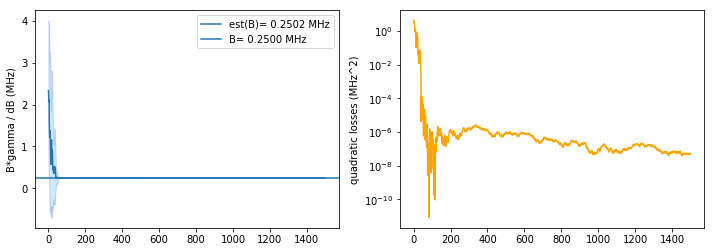

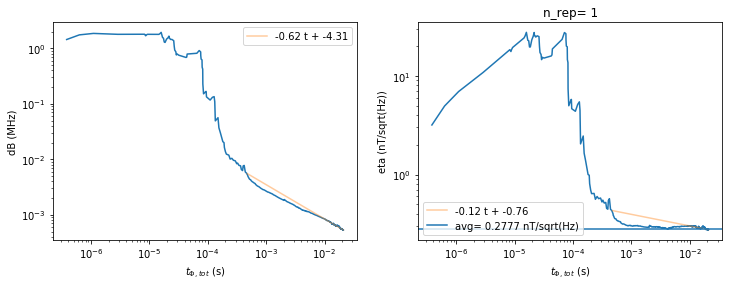

DEBUG: len z_err 0, z_corr 1500


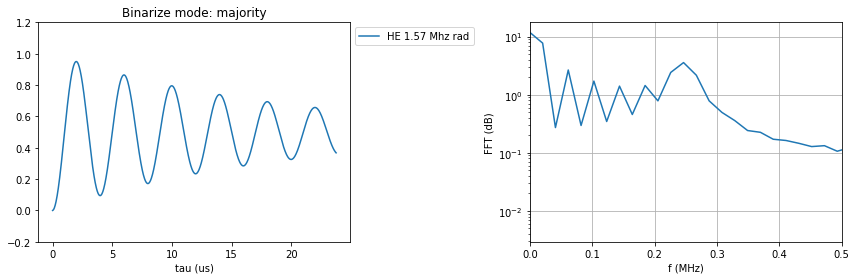

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:627: RuntimeWarning: invalid value encountered in true_divide


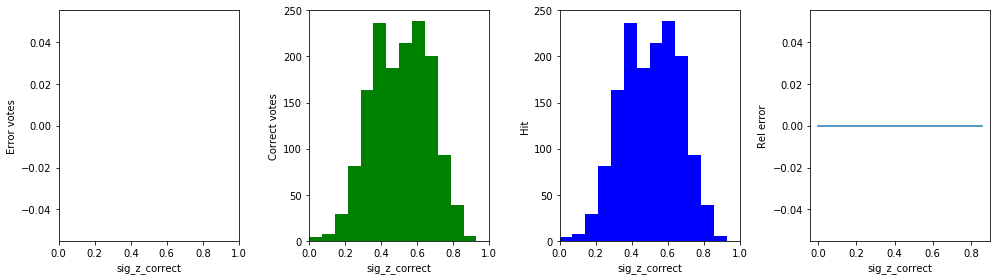

rel error= 0.09%. rel uncer= 0.21%. Error datums: 0 (0.0 %)


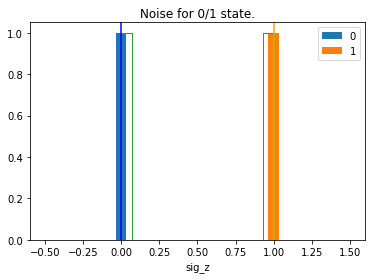

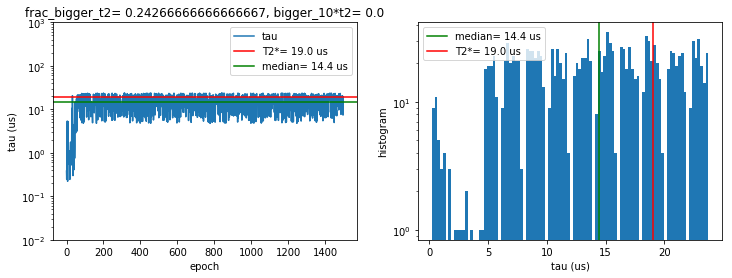

In [208]:
# run MFL
set_common_params()
reset_result()
true_omega = freq_max/20.

t2star_s = 19e-6
n_epochs = 1500

binarize_mode =  'majority' #'rand_coin' #
noise_n_rep = 1000

noise_mode = None #'Gauss'
noise_c = 0.025
"""
noise_mode = 'Poiss' #'Gauss'
noise_phot_0 = 0.03564
noise_phot_1 = 0.03168
"""

restr_tau_del_z = -0.47

run_estimation(n_epochs=n_epochs, n_sweeps=1)
print(get_params())
plot_result()
plot_scaling()
plot_zs()

errs = get_error_zs()
print("rel error= {:.2f}%. rel uncer= {:.2f}%. Error datums: {} ({:.1f} %)".format(
    100*(track_eval[-1]-true_omega)/true_omega, 100*(track_cov[-1][0][0]/track_eval[-1]),
    len(errs), len(errs)/n_epochs*100))
#print("in (epoch, val, val_noNoise): {}".format(errs))
plot_noise_model()


#plot_priors(epochs_idx=range(0, n_epochs//2, 10), n_bins=20, always_show_err=True)
#plot_priors(epochs_idx=range(0, n_epochs//10, 1), n_bins=20)
plot_taus()

#reset_result()
#run_estimation(n_epochs=n_epochs, n_sweeps=1, ret_priors_list=[0, n_epochs/2, n_epochs-1])
#plot_result()
#plot_priors(n_bins=20)


## Run MFL (Hahn)

Debug: true |A|= 1.5592 MHz, hahn_a_perp= 1.552 MHz
Debug: true alpha= 0.469 rad/pi
{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_oemga': 9.796942726860467, 'freq_min': 0.9424777960769379, 'freq_max': 31.41592653589793, 't2star_s': 7.5e-05, 'n_particles': 1000, 'noise_mode': None, 'noise_c': 0.03, 'noise_n_rep': 1000, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'binarize_remap': None, 'restr_tau_del_z': None, 'exp_mode': 'hahn', 'hahn_b_gauss': 100, 'hahn_a_parallel': 942477.7960769379}


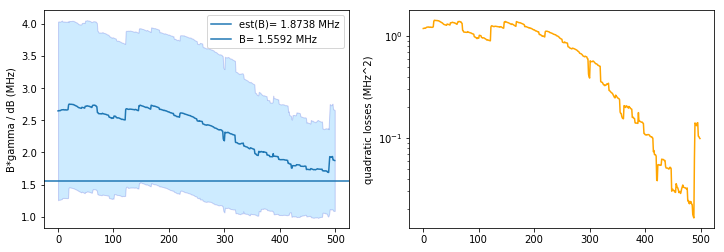

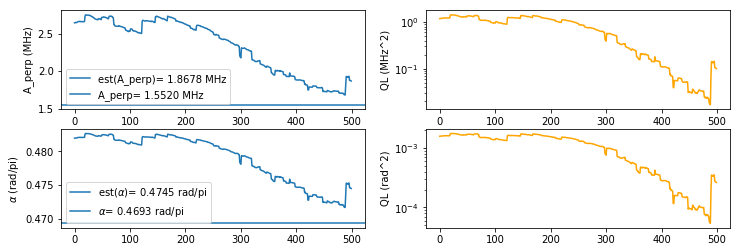

No handles with labels found to put in legend.


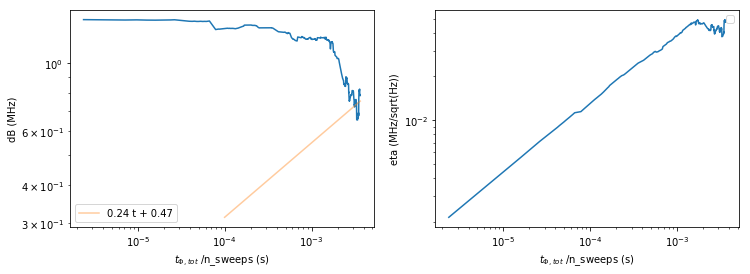

DEBUG: len z_err 0, z_corr 500


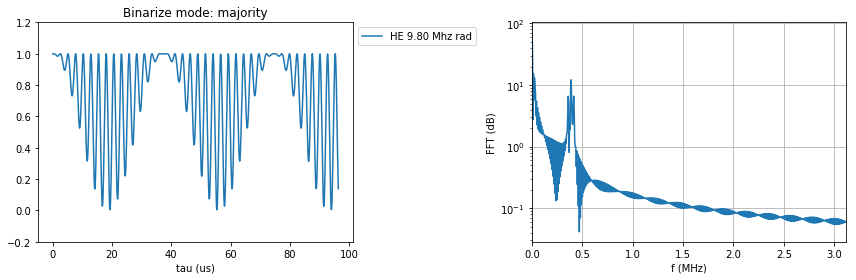

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:608: RuntimeWarning: invalid value encountered in true_divide


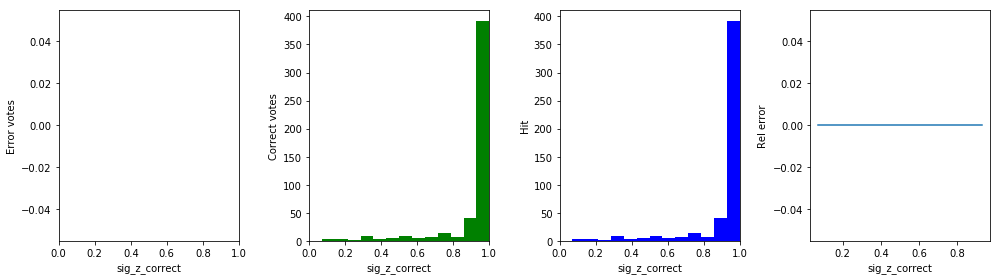

rel error= 20.17%. rel uncer= 41.87%. Error datums: 0 (0.0 %)


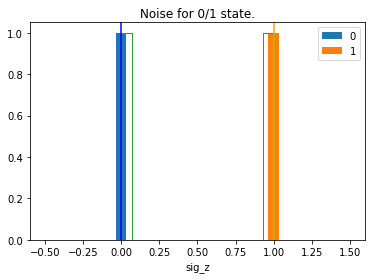

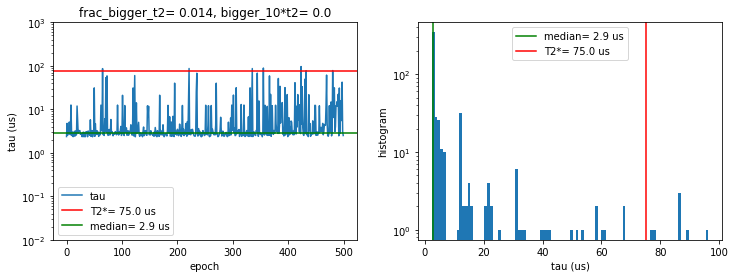

In [45]:
# run MFL
set_common_params()
reset_result()

exp_mode = 'hahn'

t2star_s = 75e-6
n_epochs = 500

binarize_mode =  'majority' #'rand_coin' #
binarize_remap = None #[0, 0.3]
noise_n_rep = 1000

hahn_b_gauss = 100

# for f2 = 400 kHz:  150, 388.2 @ 72 G 
hahn_a_parallel = 2*np.pi*0.15e6#2*np.pi* 20e3   # Hz rad  # standard: 2pi* 20, fast fail: 2*np.pi* 200e3      # good: 2*np.pi* 130e3
hahn_a_perp = 2*np.pi*4*0.388e6#2*np.pi*120e3     # Hz rad    # standard: 2pi* 130, fast fail:  2*np.pi*1300e3  
true_omega = np.sqrt((hahn_a_parallel/1e6)**2 + (hahn_a_perp/1e6)**2)     # Mhz rad
print("Debug: true |A|= {:.4f} MHz, hahn_a_perp= {:.3f} MHz".format(true_omega/(2*np.pi), hahn_a_perp/(1e6*2*np.pi)))
print("Debug: true alpha= {:.3f} rad/pi".format(np.arccos(hahn_a_parallel/(true_omega*1e6))/np.pi))
   

run_estimation(n_epochs=n_epochs, n_sweeps=1)
print(get_params())
plot_result()
plot_scaling()
plot_zs()

errs = get_error_zs()
print("rel error= {:.2f}%. rel uncer= {:.2f}%. Error datums: {} ({:.1f} %)".format(
    100*(track_eval[-1]-true_omega)/true_omega, 100*(track_cov[-1][0][0]/track_eval[-1]),
    len(errs), len(errs)/n_epochs*100))
#print("in (epoch, val, val_noNoise): {}".format(errs))
plot_noise_model()


#plot_priors(epochs_idx=range(0, n_epochs//2, 10), n_bins=20, always_show_err=True)
#plot_priors(epochs_idx=range(0, n_epochs//10, 10), n_bins=20)
plot_taus()

#reset_result()
#run_estimation(n_epochs=n_epochs, n_sweeps=1, ret_priors_list=[0, n_epochs/2, n_epochs-1])
#plot_result()
#plot_priors(n_bins=20)

## Create tau list

4 reps with 200 epochs
[25, 111, 121, 128, 136, 312, 333, 367, 415, 436, 510, 518, 620, 741, 743, 800, 808, 829, 851, 1123, 1212, 1308, 1324, 1401, 1469, 1522, 1523, 1530, 1634, 1790, 1798, 2065, 2072, 2128, 2203, 2291, 2384, 2529, 2532, 2560, 2672, 2676, 2717, 2719, 2763, 2765, 2810, 2956, 3060, 3107, 3140, 3227, 3233, 3259, 3287, 3317, 3348, 3372, 3374, 3384, 3402, 3426, 3427, 3439, 3495, 3502, 3519, 3571, 3622, 3697, 3772, 3885, 3923, 3946, 3962, 4057, 4069, 4084, 4110, 4124, 4149, 4321, 4324, 4335, 4435, 4475, 4510, 4530, 4595, 4609, 4713, 4739, 4757, 4785, 4819, 4899, 5037, 5053, 5056, 5074, 5112, 5125, 5138, 5152, 5193, 5212, 5328, 5441, 5449, 5460, 5477, 5558, 5572, 5582, 5628, 5694, 5738, 5823, 5892, 5970, 6023, 6081, 6196, 6312, 6320, 6429, 6492, 6687, 6713, 6723, 6751, 6757, 6772, 6818, 6909, 7002, 7041, 7117, 7201, 7224, 7343, 7356, 7447, 7496, 7500, 7584, 7675, 7685, 7753, 7794, 7812, 7887, 7888, 7907, 7920, 7966, 7983, 8038, 8137, 8156, 8172, 8267, 8340, 8354, 8362, 8368, 

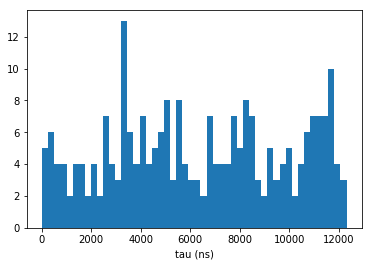

In [48]:
import random
import functools, operator
    
def create_tau_exp(n_taus_exp=245, n_epochs=150, tau_first_req_ns=25e-9):
    
    def flatten(a):
        # relatively inefficient like this
        #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
        try:
            return list(np.asarray(a).flatten())
        except TypeError as e:
            print("Error in {}".format(a))
            raise e
        
    global t2star_s, track_tau
    
    t2_ns = t2star_s*1e9
    tau_filter_thresh = 3*t2_ns
    n_mc = (n_taus_exp // n_epochs + 1) * 2   # monte carlo repetitions
    print("{} reps with {} epochs".format(n_mc, n_epochs))
    tau_acc = [tau_first_req_ns*1e9]
    
    for i in range(0, n_mc):
        reset_result()
        run_estimation(n_epochs=n_epochs, n_sweeps=1)
        tau_acc.extend(flatten(track_tau))
        tau_acc = flatten(tau_acc)
        #print("track_tau {} {}".format(len(track_tau), track_tau))
        #print("tau_acc {} {}".format(len(tau_acc), tau_acc))
        #print("flatten track_tau {} {}".format(len(flatten(track_tau)), flatten(track_tau)))
        
 
    taus_filter_ns = np.asarray(list(map(int, tau_acc)))   # to array of ints
    taus_filter_ns = sorted(list(set(taus_filter_ns[taus_filter_ns < tau_filter_thresh])))  # remove duplicates and filter
    taus_exp = random.sample(taus_filter_ns, k=n_taus_exp)

    print((sorted(taus_exp)))
    plt.hist(taus_exp, bins=50)
    plt.xlabel("tau (ns)")
    
    return taus_exp

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 3e3
tau_list = create_tau_exp(n_epochs=200)

# Sensitivity

In [449]:
# todo: currently broken 

## Monte carlo lib

In [47]:
## Monte Carlo sensitivity without overhead

t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s


def monte_carlo_mfl_runs(n_mc, n_epcohs, n_sweeps):
    """
    repeat complete mfl run
    """
    global true_omega
    
    b_list = []
    dB_list = []
    tau_list = []
    t_total_list = []
    err_list = []
    for i in range(0, n_mc):
        reset_result()
        # noise in run estimation done by sampling Gaussian
        # -> set global noise_n_rep
        try:
            (taus, B, dB, priors) = run_estimation(n_epochs=n_epochs, n_sweeps=1)  
        except NameError: # ApproximationError from mfl lib
            continue
            
        b_list.append(np.asarray(B))
        dB_list.append(np.asarray([el[0][:] for el in dB]))  # MHz rad
        tau_list.append(1e-9*np.asarray(taus)*n_sweeps)  # taus: ns -> t_phase: s
        err_list.append(np.asarray(B[:]) - true_omega)
    
    return b_list, dB_list, tau_list, err_list

def sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps):
    """
    samples n_mc mfl runs and gives for each sample estimates after 
    one complete mfl run.
    """
    global true_omega
    global t_overhead_dict
    
    b_list = []
    dB_list = []
    t_phase_list = []
    t_total_list = []
    err_list = []
    for i in range(0, n_mc):
        reset_result()
        # noise in run estimation done by sampling Gaussian
        # -> set global noise_n_rep
        try:
            (taus, B, dB, priors) = run_estimation(n_epochs=n_epochs, n_sweeps=1)  
        except NameError: # ApproximationError from mfl lib
            continue
        dB_list.append(dB[-1][0][0])  # MHz rad
        t_phase_list.append(1e-9*calc_t_total_ideal(taus)*n_sweeps)  # taus: ns -> t_phase: s
        t_total_list.append(estimate_runtime(np.asarray(taus)*1e-9, t_overhead, n_sweeps=n_sweeps))
        err_list.append(B[-1] - true_omega)
    
    return dB_list, t_phase_list, t_total_list, err_list

def estimate_final_db(n_mc, n_epochs, n_sweeps):
    dBs = sample_db_monte_carlo_mfl(n_mc)
    return np.median(dBs)

def calc_sensitivitiy(db, t_total):
    return db * np.sqrt(t_total)

def calc_t_total_ideal(tau_list):
    return np.sum(tau_list)

def estimate_runtime(tau_list_s, t_overhead_dict, n_sweeps=1):
    # see SI of Santagati (2018)
    # all units: SI
    n_epochs = len(tau_list_s)
    
    t_ov = t_overhead_dict
    
    t_total = 0
    for i in range(0, n_epochs):
        t_i = n_sweeps * tau_list_s[i][0] + t_ov['comp'] + t_ov['latency'] 
        t_total += t_i
        
    t_total += n_epochs * n_sweeps * (t_ov['t_laser'] + t_ov['t_wait'] + t_ov['t_mw'])
    
    return t_total


def b_mhzrad_to_ut(b):
    gamma = 2.8 # MHz per Gauss
    b_ut = (b / (2*np.pi)) / gamma    # Gauss
    b_ut = b_ut * 100 # uT
    
    return b_ut

def est_dB_ideal(n_epochs, n_sweeps, n_mc=100):
    """
    Runs monte carlo simulation for complete MFLs.
    Returns median values over all Monte Carlo samples.
    """
    dBs, t_phases, t_totals, errs = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    dB_est = np.median(dBs) # MHz rad
    err = np.median(errs)   # MHz rad

    dB_est_ut = b_mhzrad_to_ut(dB_est)
    err_est_ut = b_mhzrad_to_ut(err)
    
    t_phase = np.median(np.asarray(t_phases))   #s
    t_total = np.median(np.asarray(t_totals))
    
    return t_phase, t_total, dB_est_ut, err_est_ut     #s, s, uT, uT

def plot_example_sensitivity():
    n_mc = 100
    n_epochs = 50
    n_sweeps = 1
    
    # Example run for monte carlo sensitivity estimation
    dBs, taus, _, _ = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    plot_hist(dBs, label='dB after {} epochs'.format(n_epochs))
    plt.show()

    dB_est = np.median(dBs) # MHz rad
    gamma = 2.8e6*2*np.pi # MHz per Gauss
    dB_est_ut = (dB_est / (2*np.pi)) / gamma    # Gauss
    dB_est_ut = dB_est_ut * 100 # uT

    t_total = np.median(np.asarray(taus))   #s
    eta = calc_sensitivitiy(dB_est_ut, t_total)   # uT/sqrt(Hz)
    print("Median {:.2f} MHz rad, T_total {:.4f} ms, sensitivity^2: {:.4f} e-3 uT^2/Hz".format(dB_est, t_total*1e3, eta**2*1e3))


def est_dB_vs_t(n_epochs_max, n_sweeps, n_mc=5):
    ts_phase = []
    ts_total = []
    dbs = []
    errs = []
    for n_epoch in range(1, n_epochs_max):
        t, t_tot, dB, err = est_dB_ideal(n_epoch, n_sweeps, n_mc=n_mc)   #s, s, uT, uT
        #eta = calc_sensitivitiy(dB, t)   # uT/sqrt(Hz)
        
        ts_phase.append(t)
        ts_total.append(t_tot)
        dbs.append(dB)
        errs.append(err)
    
    return ts_phase, ts_total, dbs, errs
       
def plot_eta_sq_vs_t(ts, etas, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta^2 (uT^2/Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')


    ax.scatter(np.asarray(ts)*1e3, np.asarray(etas)**2, color=color, label=label)
    # error

    #plt.legend()

    return ax

def plot_eta_vs_t(ts_s, etas_ntsqrthz, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta (nT/sqrt(Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(np.asarray(ts_s)*1e3, np.asarray(etas_ntsqrthz), color=color, label=label)
    return ax
  
def plot_err_vs_t(ts, errs_uT, trueB_mhzrad, ax=None, color='red', label=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='rel error est(B) - B')
    #ax.yaxis.set_label_position("right")
    ax.set_yscale('log')
    ax.set_xscale('log')

    # error
    rel_err = abs(np.asarray(errs_uT) / b_mhzrad_to_ut(trueB_mhzrad))
    #print("rel error {}".format(rel_err))
    ax.scatter(np.asarray(ts)*1e3, rel_err, color=color, label=label)
    ax.set_ylim([min(rel_err), max(rel_err)])
    #print("{} epochs: {} ms, {} uT^2/Hz".format(n_epoch, t*1e3, eta**2))

    #plt.legend()
    
    return ax

def plot_hor_line(value, color='green', label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axhline(value, color=color, label=label)
    
    return ax

def calc_stdmes_sensitivity(tau_s, t_total_s, t2star_s, c=1):
    # see Degen Reinhard 'Quantum Sensing'
    # optimal choice: tau = t2star / 2
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    t_m = t_total_s - tau_s
    
    decay = np.exp(tau_s/t2star_s)
    #print("decay f= {} tau: {}, t2*: {}".format(decay, tau_s, t2star_s))
    eta = decay*np.sqrt(tau_s + t_m)/(gamma*c*tau_s) # Gauss / sqrt(Hz)
        
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt(t2star_s, c=1):
     # Degen17, at optimum, t_m=0
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    eta = np.sqrt(2*np.exp(1))/(gamma*c*np.sqrt(t2star_s))
    
    # difference between Degen and Rondin: sqrt(2e) in numerator
    # comes from: there is decoherence, take ~T2* (Rondin)
    # vs. optimized exp(-tau/T2*) -> T2*/2 (Degen)
    #eta = 1/(gamma*c*np.sqrt(t2star_s))
    
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt_2(t2star_s, c=1):
    # Rondin17, with C*sqrt(I*t_l) = c from Degen17
    hbar = 6.63e-34 / (2*np.pi)
    mu = 9.274e-24
    g = 2
    
    return 1e6 * hbar / (g*mu*c*np.sqrt(t2star_s))    # -> uT / sqrt(Hz)   
    

def estimate_precision(n_mc, n_epochs, tolerate_rel_err=10e-2):
        
    n_sweeps = 1
    dB_list, t_phase_list, t_total_list, err_list = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    rel_error_list = np.asarray(err_list) / true_omega
    big_errors = rel_error_list[abs(rel_error_list) > tolerate_rel_error]
    
    return 1-len(big_errors)/float(n_mc), big_errors


def calc_tau_ramsey_bmax(b_max_mhz):
    # unambiguous max tau
    
    gamma = 2*np.pi*2.8e6 # Hz (rad) per Gauss
    b_max_t = b_max_mhz *1e6 / (gamma / (2*np.pi))
    
    tau_s = np.pi / (2*gamma*b_max_t) # Waldherr 2012
    
    return tau_s

print(calc_tau_ramsey_bmax(1))

2.5e-07


## Standard mes limit

In [197]:
# Taylor 08: C=0.05, T2*=1e-6 => ~ 1 uT/sqrt(Hz)
#            C=0.3            => ~ 120 nT/sqrt(Hz)
# t_m = 0
# -> x4 bigger than here
# t_m = 5e-6
# -> fits roughly
t2star = 18.7e-6  #17.1e-6
tau = t2star/2 
C = 0.0369 
t_total = tau + 0.75e-6 + 1e-6  # laser + wait

t_ov_epoch = 1e-3 #3e-3
n_sweeps = 150  #500
t_ov_seq = t_ov_epoch/n_sweeps


eta = 1000*calc_stdmes_sensitivity(tau, t_total, t2star, c=C)
eta_ov = 1000*calc_stdmes_sensitivity(tau, t_total+t_ov_seq, t2star, c=C)
eta_opt = 1000*calc_stdmes_sensitivity_opt(t2star, c=C)
eta_opt_2 = 1000*calc_stdmes_sensitivity_opt_2(t2star, c=C)

print("T2*= {}, C= {}  \
      \n => SMS (opt) eta= {:.1f} ({:.1f}) nT/sqrt(Hz), eta^2= {:.1f} nT^2/Hz   \
      \n => incl overhead eta= {:.1f}".format(
        t2star, C, eta, eta_opt, eta**2, eta_ov))
print("Rondin14 SMS: eta= {:.1f} nT/sqrt(Hz)".format(eta_opt_2))

T2*= 1.87e-05, C= 0.0369        
 => SMS (opt) eta= 90.5 (83.1) nT/sqrt(Hz), eta^2= 8189.7 nT^2/Hz         
 => incl overhead eta= 114.5
Rondin14 SMS: eta= 35.7 nT/sqrt(Hz)


## Ramsey sensitivity vs B_max

At B= 4.862601580065354 kHz: tau_unamb= 51.41280770871628 us, eta= 22.47 nT/sqrt(Hz)
At B= 1 MHz: tau_unamb= 0.25 us, eta= 537.24 nT/sqrt(Hz)


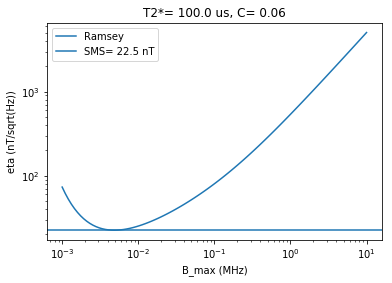

In [48]:
t2star = 100e-6  #17.1e-6
tau = t2star/2
t_laser = 0.75e-6
t_wait = 1e-6
t_total = tau + t_laser + t_wait
C = 0.06
eta_min = 1000*calc_stdmes_sensitivity(tau, t_total, t2star, c=C)

bmax_list = np.geomspace(0.1e-2, 10, 100)    # MHz
eta_list = []

for b_mhz in bmax_list:
    tau_i_s = calc_tau_ramsey_bmax(b_mhz)
    t_total = tau_i_s + t_laser + t_wait
    
    eta_nT = 1000*calc_stdmes_sensitivity(tau_i_s, t_total, t2star, c=C)
    eta_list.append(eta_nT)


    
plt.plot(bmax_list, eta_list, label="Ramsey")
plt.axhline(eta_min, label="SMS= {:.1f} nT".format(eta_min))

plt.title("T2*= {:.1f} us, C= {}".format(t2star*1e6, C))
plt.xlabel("B_max (MHz)")
plt.ylabel("eta (nT/sqrt(Hz))")
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()

idx_eta_min = np.argmin(eta_list)
tau_eta_min = calc_tau_ramsey_bmax(bmax_list[idx_eta_min])
t_total = tau_eta_min + t_laser + t_wait
print("At B= {} kHz: tau_unamb= {} us, eta= {:.2f} nT/sqrt(Hz)".format(1000*bmax_list[idx_eta_min], tau_eta_min*1e6, 
                                                  1000*calc_stdmes_sensitivity(tau_eta_min, t_total, t2star, c=C)))

tau_1mhz_s = calc_tau_ramsey_bmax(1)
t_total = tau_1mhz_s + t_laser + t_wait
print("At B= 1 MHz: tau_unamb= {} us, eta= {:.2f} nT/sqrt(Hz)".format(tau_1mhz_s*1e6, 
                                                  1000*calc_stdmes_sensitivity(tau_1mhz_s, t_total, t2star, c=C)))

## Averaged MFL runs

{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_omega': 3.141592653589793, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1.9e-05, 'n_particles': 1000, 'noise_mode': 'Gauss', 'noise_c': 0.05, 'noise_n_rep': 750.0, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'binarize_remap': None, 'restr_tau_del_z': None, 'exp_mode': 'ramsey', 'hahn_b_gauss': 10, 'hahn_a_parallel': 500000.0, 'n_epochs': 1400}


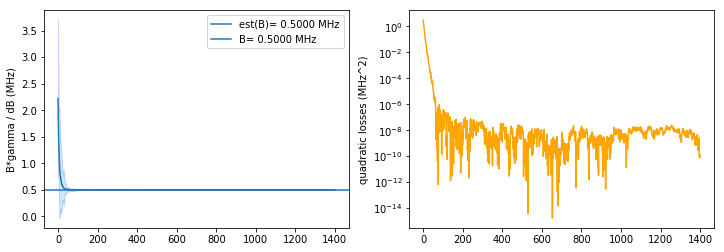

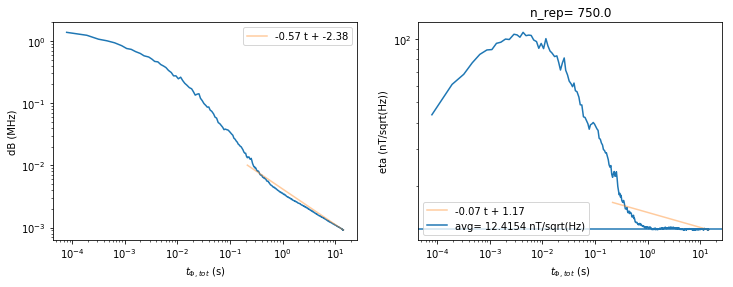

In [209]:
set_common_params()

t2star_s = 19e-6
t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s
n_sweeps = 1  # not for noise, only calc t

# monte carlo params
n_epochs = 1400
n_mc = 200

# noise params
noise_mode = None
noise_mode = 'Gauss'
noise_c = 0.05
noise_n_rep = 7.5e2

freq_max = 2*np.pi*5

bs, dBs, tau_list, errs = monte_carlo_mfl_runs(n_mc, n_epochs, n_sweeps)
   
bs_median = np.median(bs, axis=0).flatten()
dBs_median_mhz = np.median(dBs, axis=0).flatten()/(2*np.pi)  # MHz
taus_median = np.median(tau_list, axis=0).flatten()
taus_tot = calc_total_runtime(taus_median)  # assume n_sweeps = 1!

#print(np.asarray(tau_list)[:,0])
#print(taus_median[0])

print(get_params())

plot_result(bs_median)  # ATTENTION: no dB_median provided here -> from last mfl run
plot_scaling(taus_median, dBs_median_mhz, n_rep=noise_n_rep)

save = False
if save:
    save_folder = "C:/Users/Timo/Desktop/MFL_results"
    save_folder = save_folder + '.' + str(get_file_index(save_folder))
    enable_safe(save_folder)
    save_notebook(dir())

    np.savetxt(save_folder + "/taus_median.txt", taus_median)
    np.savetxt(save_folder + "/taus_tot.txt", taus_tot)
    np.savetxt(save_folder + "/dBs_median.txt", dBs_median_mhz)

## Averaged MFL vs B

In [ ]:
set_common_params()

freq_max = 2*np.pi*5
true_omega_mhz_list = np.linspace(freq_max/50, freq_max/20, 150)   # mhz rad
#true_omega_mhz_list = np.linspace(2*np.pi*0.001, freq_max/50, 100)   # mhz rad

t2star_s = 19e-6
t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s
n_sweeps = 1  # not for noise, only calc t

# monte carlo params
n_epochs = 1400   # MAKRE SURE LONG ENOUGH!
n_mc = 200

# noise params
noise_mode = None
noise_mode = 'Gauss'
noise_c = 0.05
noise_n_rep = 0.75e3
#"""
eta_mean_nT = []
for i, omega in enumerate(true_omega_mhz_list):
    true_omega = omega
    bs, dBs, tau_list, errs = monte_carlo_mfl_runs(n_mc, n_epochs, n_sweeps)
    

    dBs_median_mhz = np.median(dBs, axis=0).flatten()/(2*np.pi)  # MHz 
    taus_median = np.median(tau_list, axis=0).flatten()*noise_n_rep
    taus_tot = calc_total_runtime(taus_median)

    n_points_fit = int(n_epochs/5)
    eta_phase_nT = np.sqrt(taus_tot) * dBs_median_mhz / (2.8*1e-4)
    eta_phase_mean = np.average(eta_phase_nT[-n_points_fit:])
    eta_mean_nT.append(eta_phase_mean)
    print("[{}/{}] true omega= {:.4f} Mhz / {:.4f} uT -> eta= {:.4f} nT/sqrt(Hz)".format(
                                                                i, len(true_omega_mhz_list),
                                                                get_params()['true_omega']/(2*np.pi),
                                                                get_params()['true_omega']/(2.8*1e-4*2*np.pi),
                                                                eta_phase_mean))

#"""   

save = True
if save:
    save_folder = "C:/Users/Timo/Desktop/MFL_results"
    save_folder = save_folder + '.' + str(get_file_index(save_folder))
    enable_safe(save_folder)
    save_notebook(dir())

    np.savetxt(save_folder + "/B_mhz_rad.txt", true_omega_mhz_list)
    np.savetxt(save_folder + "/eta_mean_nT.txt", eta_mean_nT)


plt.plot(true_omega_mhz_list/(2*np.pi), eta_mean_nT/np.max(eta_mean_nT))
plt.title("avg MFL runs, n_mc= {}".format(n_mc))
plt.ylabel(r"rel $\eta_{mean}$")
plt.xlabel("B (MHz)")

print(get_params())

## eta vs f_max

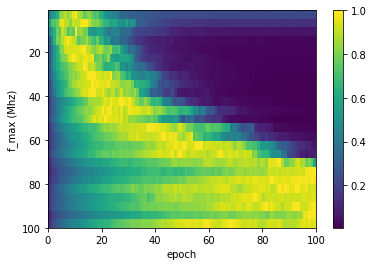

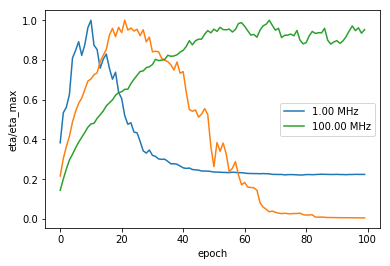

In [73]:
t2star_s = 10e-6
t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s
n_sweeps = 1  # not for noise, only calc t

# monte carlo params
n_epochs = 100
n_mc = 25

# noise params
noise_mode = None


f_max_list = np.linspace(1,100,25)*2*np.pi
freq_max = 2*np.pi*50

taus_list = []
tau_tot_list = []
dBs_list = []
eta_mhz_list = []

#res_img = np.zeros([len(f_max_list), n_epochs])

for i, f_max in enumerate(f_max_list):
    break
    freq_max = f_max
    bs, dBs, tau_list, errs = monte_carlo_mfl_runs(n_mc, n_epochs, n_sweeps)
   
    bs_median = np.median(bs, axis=0).flatten()
    dBs_median_mhz = np.median(dBs, axis=0).flatten()/(2*np.pi)  # MHz
    taus_median = np.median(tau_list, axis=0).flatten()
    taus_tot = calc_total_runtime(taus_median)
    
    taus_list.append(taus_median)
    tau_tot = calc_total_runtime(taus_median)
    tau_tot_list.append(tau_tot)
    dBs_list.append(dBs_median_mhz)
    eta_mhz = np.sqrt(tau_tot)*dBs_median_mhz
    eta_mhz_list.append(eta_mhz)
    
    res_img[i,:] = eta_mhz/max(eta_mhz)
    

plt.imshow(res_img, extent=[0, n_epochs, f_max_list[-1]/(2*np.pi), f_max_list[0]/(2*np.pi)], aspect='auto')
plt.colorbar()
plt.xlabel("epoch")
plt.ylabel("f_max (Mhz)")
#plt.xscale('log')

plt.figure()
plt.plot(res_img[0,:], label="{:.2f} MHz".format(f_max_list[0]/(2*np.pi)))
plt.plot(res_img[int(len(f_max_list)/2),:])
plt.plot(res_img[-1,:], label="{:.2f} MHz".format(f_max_list[-1]/(2*np.pi)))
plt.xlabel("epoch")
plt.ylabel("eta/eta_max")
plt.legend()



## Ideal sensitivity

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


t_overhead: {'comp': 0.0, 'latency': 0.0, 't_laser': 0.0, 't_wait': 0.0, 't_mw': 0.0}


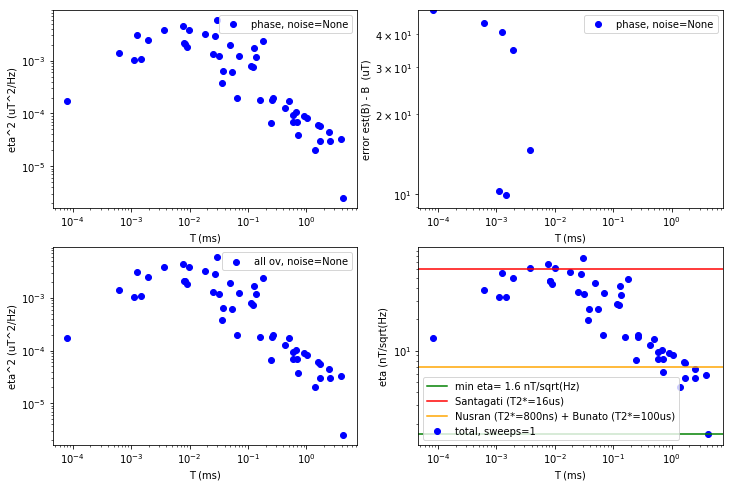

In [115]:
#plot_example_sensitivity()
# todo: include and check
# no noise
# T2* = ?
# overhead times

# experimental params
t2star = 0e-6
t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s
n_sweeps = 1  # not for noise, only calc t

# monte carlo params
max_epochs = 50
n_mc = 10

# noise params
noise_mode = None

fig, axs = plt.subplots(2,2, figsize=(12,8))
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]


taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
etas_total = calc_sensitivitiy(dbs, t_totals)
plot_eta_sq_vs_t(taus, etas, ax=ax1, label='phase, noise={}'.format(noise_mode), color='blue')
plot_err_vs_t(taus, errs, ax=ax2, label='phase, noise={}'.format(noise_mode), color='blue')
ax2.set_ylim([np.min(errs),np.max(errs)])

plot_eta_sq_vs_t(t_totals, etas_total, ax=ax3, label='all ov, noise={}'.format(noise_mode), color='blue'),

# eta plot
plot_eta_vs_t(t_totals, np.asarray(etas_total)*1e3, ax=ax4, label='total, sweeps={}'.format(n_sweeps), color='blue')
plot_hor_line(1e3*min(etas_total), label='min eta= {:.1f} nT/sqrt(Hz)'.format(1e3*min(etas_total)), ax=ax4)
#plot_hor_line(1e3*calc_stdmes_sensitivity(t2star/2, t2star/2+2e-6, t2star), label='SMS T2*={}'.format(t2star), ax=ax4)
plot_hor_line(60, label='Santagati (T2*=16us)'.format(t2star), ax=ax4, color='red')
plot_hor_line(7, label='Nusran (T2*=800ns) + Bunato (T2*=100us)'.format(t2star), ax=ax4, color='orange')

ax2.legend()
ax1.legend()
ax3.legend()
ax4.legend()

print("t_overhead: {}".format(t_overhead))


T2*= 1.35e-05, C= 0.021 
 => SMS (opt) eta= 191.0 (171.8) nT/sqrt(Hz), eta^2= 36497.2 nT^2/Hz
Rondin14 SMS: eta= 73.7 nT/sqrt(Hz)


## Experimental sensitivity

In [145]:
#plot_example_sensitivity()
# todo: include and check
# no noise
# T2* = ?
# overhead times

# SEEMS BROKEN (t_total, t_phase_total calcs)

# experimental params
t2star = 13e-6
t_overhead = {'comp':1e-3, 'latency':0e-6, 't_laser':650e-9, 't_wait':1000e-9, 't_mw':50e-9}   # s

# monte carlo params
max_epochs = 100
n_mc = 2

# noise params
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3

n_sweeps = noise_n_rep
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
etas_total = calc_sensitivitiy(dbs, t_totals)




C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


taus [4.4662822979556424e-05, 0.0006802344649233403, 0.0008052583893868186, 0.0009174207748657139, 0.001107855761623107, 0.0015305488051548127, 0.0045877878386645105, 0.006297079901985785, 0.006312822386825059, 0.00685018913777728, 0.006949834421205044, 0.010392142303591617, 0.011837312762264665, 0.012873523026176914, 0.01371839634231992, 0.014250578932438838, 0.014888577929692715, 0.016869771818599583, 0.020654784259041152, 0.02560879187690951, 0.031038845074720257, 0.031691766616167245, 0.04356262366414434, 0.046527319563970174, 0.048364532886016595, 0.054726771174004554, 0.05479670503780616, 0.058707026769318715, 0.06015218122676949, 0.06747744657291666, 0.07029069010827606, 0.09085380951207478, 0.10285838754404954, 0.12319606899011386, 0.12524343776564992, 0.1367332551455156, 0.14117516405476255, 0.1576391224733032, 0.16959936105684423, 0.1865679473177512, 0.18706233315045928, 0.22012402848339643, 0.2402444829595976, 0.25270683581939124, 0.2702121957170446, 0.2729380824836306, 0.30

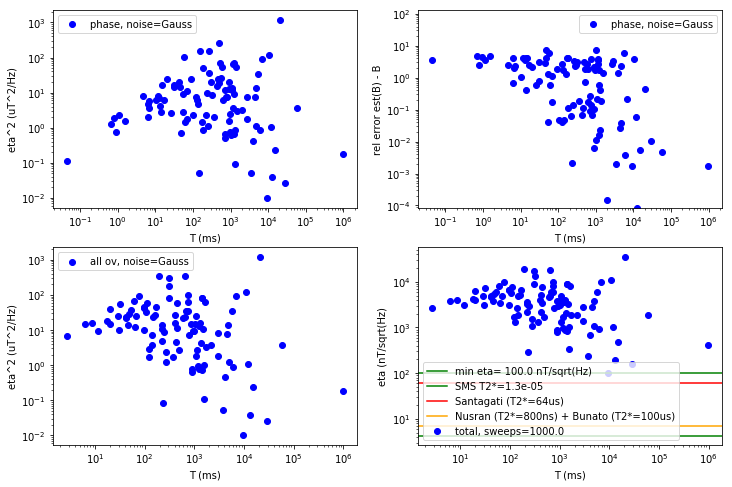

In [148]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

plot_eta_sq_vs_t(taus, etas, ax=ax1, label='phase, noise={}'.format(noise_mode), color='blue')
plot_err_vs_t(taus, errs, true_omega, ax=ax2, label='phase, noise={}'.format(noise_mode), color='blue')
ax2.set_ylim([np.min(errs),np.max(errs)])

plot_eta_sq_vs_t(t_totals, etas_total, ax=ax3, label='all ov, noise={}'.format(noise_mode), color='blue'),

print("taus {}".format(sorted(taus)))
print("t_totals {}".format(sorted(t_totals)))

# eta plot
plot_eta_vs_t(t_totals, np.asarray(etas_total)*1e3, ax=ax4, label='total, sweeps={}'.format(n_sweeps), color='blue')
plot_hor_line(1e3*min(etas_total), label='min eta= {:.1f} nT/sqrt(Hz)'.format(1e3*min(etas_total)), ax=ax4)
plot_hor_line(1e3*calc_stdmes_sensitivity(t2star/2, t2star/2+2e-6, t2star), label='SMS T2*={}'.format(t2star), ax=ax4)
plot_hor_line(60, label='Santagati (T2*=64us)'.format(t2star), ax=ax4, color='red')
plot_hor_line(7, label='Nusran (T2*=800ns) + Bunato (T2*=100us)'.format(t2star), ax=ax4, color='orange')

"""
n_sweeps = 10
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
plot_eta_sq_vs_t(taus, etas, ax=ax1, color='green', label='sweeps={}'.format(n_sweeps))
plot_err_vs_t(taus, errs, ax=ax2, color='green', label='sweeps={}'.format(n_sweeps))
"""
"""
n_sweeps = 1
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
plot_eta_sq_vs_t(taus, etas, ax=ax1, color='orange', label='sweeps={}'.format(n_sweeps))
plot_err_vs_t(taus, errs, ax=ax2, color='orange', label='sweeps={}'.format(n_sweeps))
"""
ax2.legend()
ax1.legend()
ax3.legend()
ax4.legend()

print("t_overhead: {}".format(t_overhead))


# Noise

## Precision vs n_sweeps

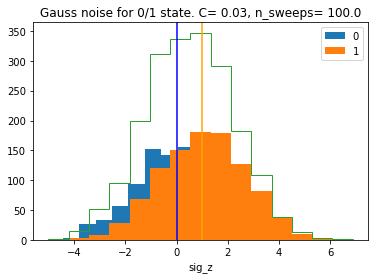

{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_oemga': 3.141592653589793, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1e-05, 'n_particles': 1000, 'noise_mode': 'Gauss', 'noise_c': 0.03, 'noise_n_rep': 100.0, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'restr_tau_del_z': None}
Noise Gauss n_rep=100: precision 0.0% big errors (10/10), [ 818.96911268  -20.72465804  133.93683398 1022.78479211  106.92674025
  249.7534278   812.56792093  657.59579914  249.12567401  679.05503575] %
Noise None n_rep=100: precision 100.0% big errors (0/10), [] %
Done


In [154]:
set_common_params()

# monte carlo params
max_epochs = 150
n_sweeps = 1
n_mc = 10
tolerate_rel_error = 10e-2
        
# Noise
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e2
binarize_mode = 'majority'  #'rand_coin'
plot_noise_model()

print(get_params())

# precision @ sweeps = fixed
rel_precision, big_errors = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
#print("dB_list {}, err_list {}, rel_err {}".format(dB_list, err_list, rel_error_list))
print("Noise {} n_rep={}: precision {:.1f}% big errors ({}/{}), {} %".format(noise_mode, int(noise_n_rep), 100*rel_precision,
                                                               len(big_errors), n_mc, 100*big_errors))
# NO NOISE
noise_mode = None
rel_precision, big_errors = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
print("Noise {} n_rep={}: precision {:.1f}% big errors ({}/{}), {} %".format(noise_mode, int(noise_n_rep), 100*rel_precision,
                                                               len(big_errors), n_mc, 100*big_errors))

# precision vs n_sweeps
rep_list = np.linspace(1e2, 5e3, 10)
rep_list = np.geomspace(1e2, 5e3, 20)
noise_mode = 'Gauss'
noise_c = 0.03
precision_list = []
label = '[{}] c= {}, mfl_a= {}, mfl_th= {}, restr_tau_del_z= {}'.format(noise_mode, 
                                                                        noise_c, mfl_res_a, mfl_res_th, restr_tau_del_z)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list.append(rel_precision)

    

noise_mode = 'Gauss'
noise_c = 0.03
restr_tau_del_z = -0.45
precision_list_2 = []
label_2 = '[{}] c= {}, mfl_a= {}, mfl_th= {}, restr_tau_del_z= {}'.format(noise_mode, 
                                                                        noise_c, mfl_res_a, mfl_res_th, restr_tau_del_z)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list_2.append(rel_precision)
   
"""
noise_mode = None
#mfl_res_a = 0.85
#mfl_res_th = 0.4
precision_list_2 = []
label_2 = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list_2.append(rel_precision)
"""
"""
noise_mode = 'Poiss' #'Gauss'
noise_phot_0 = 0.03564
noise_phot_1 = 0.03168
precision_list_3 = []
label_3 = '[{}] phot_1= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_phot_1, mfl_res_a, mfl_res_th)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list_3.append(rel_precision)
""" 
print("Done")
    

max_epochs= 150, n_mc= 10, tolerate_rel_error= 0.1


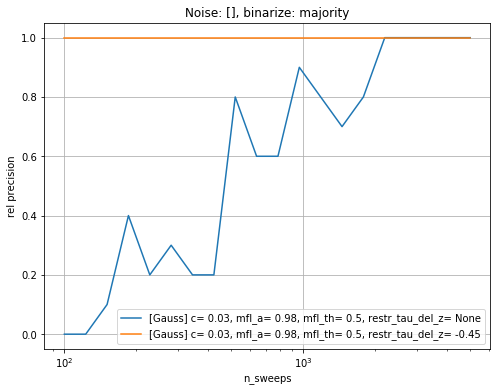

In [155]:
plt.figure(figsize=(8,6))
plt.plot(rep_list, precision_list, label=label)
plt.title('Noise: [], binarize: {}'.format(binarize_mode))
plt.plot(rep_list, precision_list_2, label=label_2)
#plt.plot(rep_list, precision_list_3, label=label_3)
plt.legend()
plt.grid()

ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('n_sweeps')
plt.ylabel('rel precision')

print("max_epochs= {}, n_mc= {}, tolerate_rel_error= {}".format(max_epochs, n_mc, tolerate_rel_error))

## Precision vs freq_max

In [452]:
set_common_params()

# monte carlo params
max_epochs = 100
n_sweeps = 1
n_mc = 25
tolerate_rel_error = 10e-2
       
# Noise
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3
#plot_noise_model()

# precision vs f_max
f_max_mhz_list = np.linspace(true_omega, 20*true_omega, 12)/(2.*np.pi)
precision_list = []
label = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for f in f_max_mhz_list:
    freq_max = f*2*np.pi
    rel_precision, _ = estimate_precision(n_mc, max_epochs)
    precision_list.append(rel_precision)
    
print("Done")

Done


Text(0, 0.5, 'rel precision')

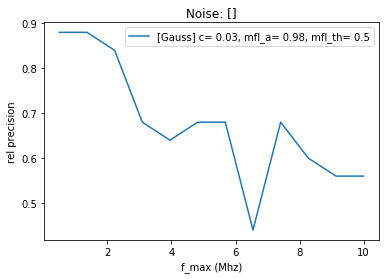

In [453]:
plt.plot(f_max_mhz_list, precision_list, label=label)
plt.title('Noise: []')
plt.legend()

plt.xlabel('f_max (Mhz)')
plt.ylabel('rel precision')

# Precision vs restr_tau, n_sweeps

In [180]:
set_common_params()

max_epochs = 150
n_mc = 200
tolerate_rel_error = 10e-2

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3
t2star_s = 15e-6

rep_list = rep_list = np.geomspace(1e2, 5e3, 20)
restr_tau_list = np.linspace(-0.49, -0.25, 10)

prec_array = np.zeros([len(rep_list), len(restr_tau_list)])

for i, n_rep in enumerate(rep_list):
    print("[{}/{}]".format(i, len(rep_list)))
    for j, r_td in enumerate(restr_tau_list):
        
        noise_n_rep = n_rep
        restr_tau_del_z = r_td
        
        #print(get_params())
        
        try:
            rel_precision, _ = estimate_precision(n_mc, max_epochs)
        except NameError: # by not defined ApproximationWarning
            rel_precision = 0
        prec_array[i, j] = rel_precision

[0/20]
[1/20]
[2/20]
[3/20]
[4/20]
[5/20]
[6/20]
[7/20]
[8/20]
[9/20]
[10/20]
[11/20]
[12/20]
[13/20]
[14/20]
[15/20]
[16/20]
[17/20]
[18/20]
[19/20]


{'mfl_res_a': 0.98, 'mfl_res_th': 0.5, 'true_oemga': 3.141592653589793, 'freq_min': 0, 'freq_max': 31.41592653589793, 't2star_s': 1.5e-05, 'n_particles': 1000, 'noise_mode': 'Gauss', 'noise_c': 0.03, 'noise_n_rep': 4999.999999999999, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'rand_coin', 'restr_tau_del_z': -0.25}


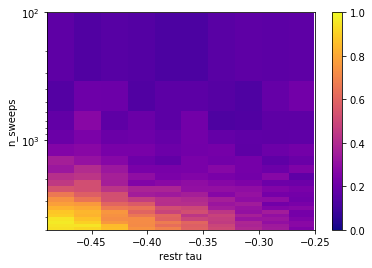

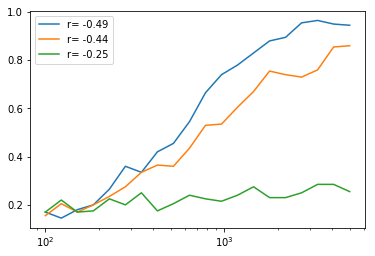

In [185]:
print(get_params())

aspect = (restr_tau_list[-1] - restr_tau_list[0])/(rep_list[-1] - rep_list[0])
plt.imshow(prec_array, extent=[restr_tau_list[0], restr_tau_list[-1], rep_list[-1], rep_list[0]], cmap='plasma', vmax=1, vmin=0.0)
plt.colorbar()
plt.xlabel("restr tau")
plt.ylabel("n_sweeps")
plt.yscale('log')
plt.show()

i_rep = 0
plt.plot(rep_list, prec_array[:,i_rep], label="r= {:.2f}".format(restr_tau_list[i_rep]))
i_rep = 2
plt.plot(rep_list, prec_array[:,i_rep], label="r= {:.2f}".format(restr_tau_list[i_rep]))
i_rep = -1
plt.plot(rep_list, prec_array[:,i_rep], label="r= {:.2f}".format(restr_tau_list[i_rep]))
plt.xscale('log')
plt.legend()

## Precision vs f, f_max @ n_rep=const

In [454]:
set_common_params()

max_epochs = 100
n_mc = 100
tolerate_rel_error = 10e-2

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3
t2star_s = 15e-6

freq_max_mhz_list = np.linspace(0.2, 10, 50)
omega_true_mhz_list = np.linspace(0.1, 2.5, 50)

prec_array = np.zeros([len(freq_max_mhz_list), len(omega_true_mhz_list)])

for i, f_max in enumerate(freq_max_mhz_list):
    for j, omega in enumerate(omega_true_mhz_list):
        
        true_omega = omega * 2*np.pi
        freq_max = f_max * 2*np.pi
        
        #print(get_params())
        
        try:
            rel_precision, _ = estimate_precision(n_mc, max_epochs)
        except NameError: # by not defined ApproximationWarning
            rel_precision = 0
        prec_array[i, j] = rel_precision

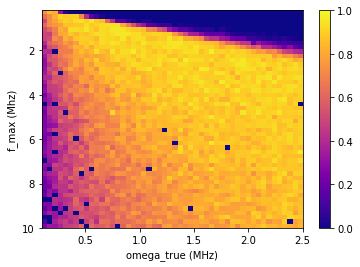

(0, 1)

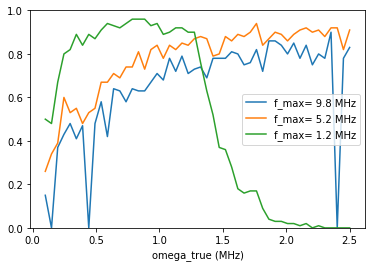

In [461]:
# todo: double check extend / x,y axis!
aspect = 0.05*(freq_max_mhz_list[-1] - freq_max_mhz_list[0])/(omega_true_mhz_list[-1] - omega_true_mhz_list[0])
plt.imshow(prec_array, extent=[omega_true_mhz_list[0], omega_true_mhz_list[-1], freq_max_mhz_list[-1], freq_max_mhz_list[0]], aspect=aspect, cmap='plasma', vmax=1, vmin=0.0)
plt.colorbar()
plt.xlabel("omega_true (MHz)")
plt.ylabel("f_max (Mhz)")
plt.show()

plt.figure()
i_max = -2
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
#i_max = -4
#plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
i_max = -25
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
i_max = -45
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
plt.xlabel("omega_true (MHz)")
plt.legend()
axes = plt.gca()
axes.set_ylim([0,1])


## Precision vs mfl_a, mfl_th @ n_rep=const

In [138]:
set_common_params()

max_epochs = 100
n_sweeps = 1
n_mc = 200
tolerate_rel_error = 10e-2

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3

a_list = np.linspace(0.9, 0.91, 20)
th_list = np.linspace(0.7, 0.71, 20)

prec_array = np.zeros([len(a_list), len(th_list)])

for i, a in enumerate(a_list):
    for j, th in enumerate(th_list):
        
        mfl_res_a = a
        mfl_res_th = th
        
        try:
            rel_precision, _ = estimate_precision(n_mc, max_epochs)
        except NameError: # by not defined ApproximationWarning
            rel_precision = 0
        prec_array[i, j] = rel_precision
        
        


KeyboardInterrupt: 

Text(0, 0.5, 'mfl_resampling_a')

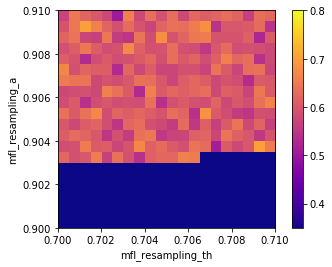

In [140]:
#prec_array
# todo: double check extend / x,y axis!
aspect = 1/(a_list[-1] - a_list[0])/(th_list[-1] - th_list[0])
plt.imshow(prec_array, extent=[th_list[0], th_list[-1], a_list[0], a_list[-1]], aspect=1, cmap='plasma', vmax=0.8, vmin=0.35)
plt.colorbar()
plt.xlabel("mfl_resampling_th")
plt.ylabel("mfl_resampling_a")


# Profile with cProfile

In [ ]:
import cProfile
cProfile.run('run_estimation()', 'profile_data')
import pstats
p = pstats.Stats('profile_data')
p.strip_dirs().sort_stats('cumtime').print_stats()


In [25]:
# Profile with line_profiler
%lprun -f 'run_estimation()'

ERROR:root:Line magic function `%lprun` not found.


In [59]:
print([el[0][0] for el in track_cov])

[17.07611884033822, 13.249580505014727, 12.339597483243331, 12.984399607527504, 8.158266110562193, 6.2281634943274184, 6.726487211507631, 8.564977878675485, 13.55994277132737, 13.311815534021568, 15.573371350073858, 15.754533576569587, 15.837485666062232, 15.726994929095762, 14.254352438035522, 14.395552886198828, 14.113545856361661, 13.817846033489209, 13.04680764999155, 12.60966765734167, 12.525834481732478, 11.445324314649744, 8.627661578750393, 9.183857419670753, 5.487120363434834, 3.6459408905444093, 3.5784061470777107, 3.2043710241226786, 2.5230312715456575, 2.2215292867938734, 2.4099290941852196, 2.0422560985203173, 1.2216004683696857, 1.1007305185709826, 1.0773851781552628, 0.9925201153209505, 0.76303542053975, 0.7240153347161595, 1.4577294671594816, 1.5643225588089174, 1.3215860577944611, 1.4203935215021866, 1.1706668112360024, 1.1720554415801994, 1.190363673425998, 1.2406406996301453, 1.2002734278061742, 1.2543283902020452, 1.2305476462241662, 1.146890866310617, 1.08846808846

[9.42978085] [[0.00235536]]


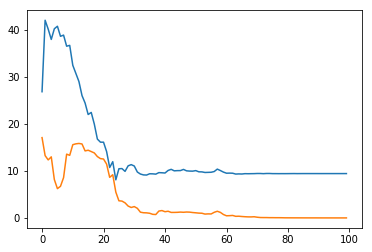

DEBUG: len z_err 155, z_corr 245


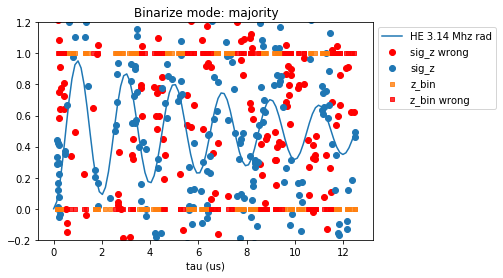

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:338: RuntimeWarning: invalid value encountered in true_divide


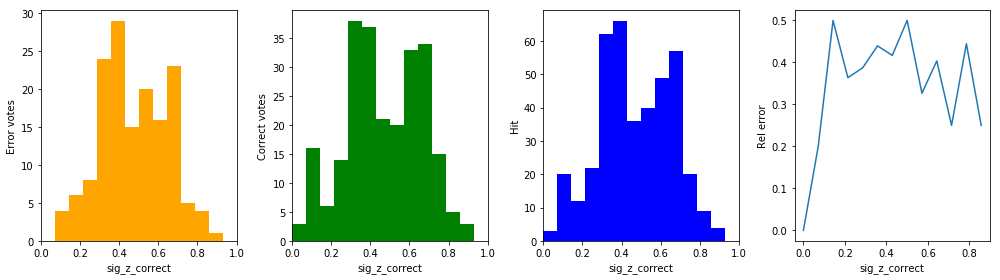

In [6]:
plot_zs()
